# Compensation Notebook for Quick Analysis

Hi! Welcome :) This code was originally created by Marilena Lykiardopoulou and was automated and commented by Annabelle Czihaly. 

The goal of this script is to create composite compensation plots like this one: 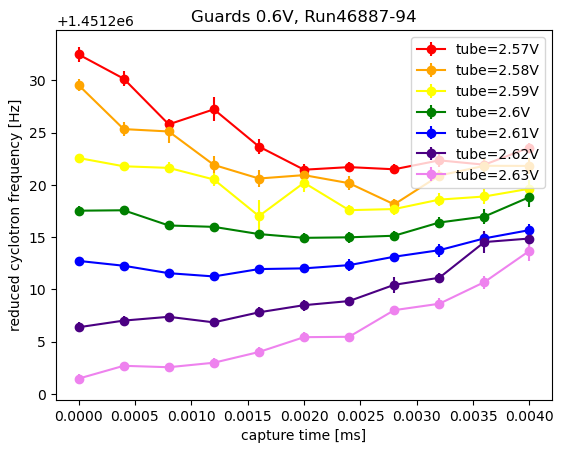The plot is automatically created when run numbers, tube values, and center frequencies are inputted. This is ideal for quick analysis. If you are looking to fit each scan individually, please see Compensation Notebook for Extensive Analysis.

Make a copy and try with your own data! Need a hand? Please forward your questions to aczihaly@triumf.ca

#### import packages

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

#### define various plotting functions

In [7]:
def gaussian(x, a, b, c, d):
    return -a*np.exp(-(x-b)**2/(2*c**2))+d

def line(x,a,b):
    return a*x+b

def parabola(x,a,b,c):
    return a*(x-b)**2+c

#### define tof_resonance which needs 4 inputs: a dataframe, center frequency, deviation, npoints

In [8]:
def tof_res(df, fc, dev, npoints): 

    ToF = []
    counts = []
    err_ToF = []
    x = []
    sigma = []
    
    for i in range(0, max(df['x_step_idx'])+1): # for i in range 0 to the max value in x_step_idx col (inclusive)
        
        df_i = df.loc[df['x_step_idx']==i] # df_i is a new dataframe that has all rows where the value in df['x_step_idx'] is equal to i
        
        ToF.append(np.average(df_i['tof']))
        err_ToF.append(np.std(df_i['tof'])/np.sqrt(len(df))) 
        sigma.append(np.std(df_i['tof']))
        x.append(fc-dev+i*((dev*2)/(npoints))) 
        counts.append(len(df_i['tof']))
        
    return ToF, counts, err_ToF, x, sigma

#### define fit_ref which needs 6 inputs: a dataframe, center frequency, deviation, npoints, fit parameters, and tof

In [9]:
def fit_ref(df, fc, dev, npoints, p0, tof): # fits resonance for different capture times and outputs center frequency and error
    
    centre_freq = []
    err_center_freq = []
    capture_times = []
    
    # if fitting multiple resonances, have range start at 0
    # if fitting a single resonance, have range start at -1
    
    for i in range(0, max(df['y_step_idx'])+1): 
        df_i = df.loc[df['y_step_idx']==i]
        df_j = df_i.loc[df_i['tof']<=tof]
        
        ToF, counts, err_ToF, x, sigma = tof_res(df_j, fc, dev, npoints)
        
        # turn df_i['step_value_ppg'] into a list
        # from this list, remove all [] brackets
        # make all values floats
        # get the average of them 
        
        capture_times.append(np.average([float(item.strip('[]')) for item in df_i['step_value_ppg'].str.split(',').str[0]]))
        
        popt, pcov = curve_fit(gaussian, x, ToF, p0, bounds = ([p0[0]-10, p0[1]-60,p0[2]-5,p0[3]-20],[p0[0]+10, p0[1]+60,p0[2]+5,p0[3]+20]))
        a,b,c,d = popt
        perr = np.sqrt(np.diag(pcov))
        centre_freq.append(popt[1])
        err_center_freq.append(perr[1])     
        
    return centre_freq, err_center_freq, capture_times

#### auto create composite plot with custom center frequency. Must enter run #'s, center frequencies, and tube values!

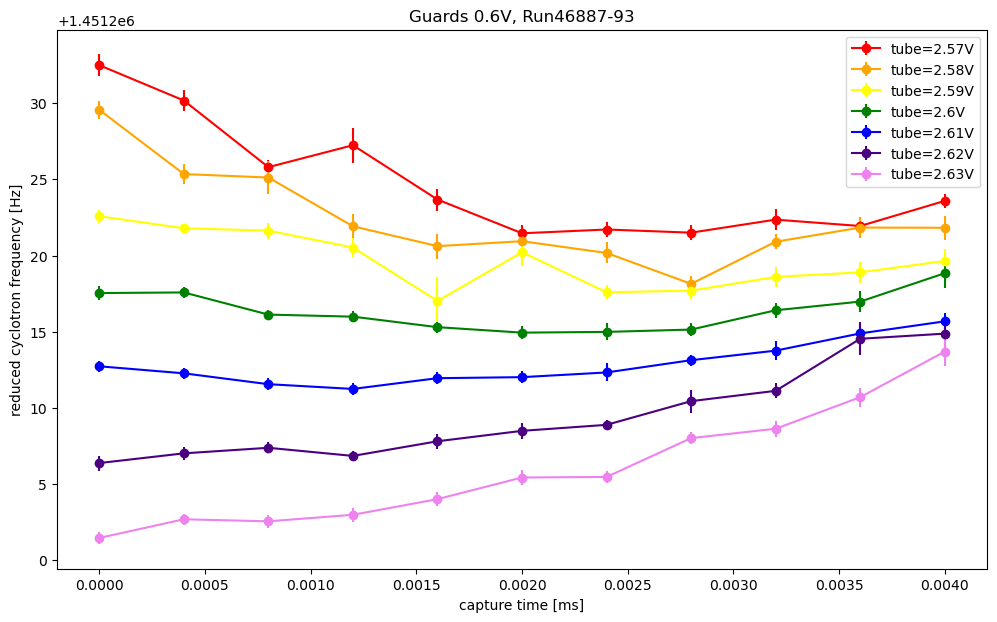

In [10]:
# please enter run numbers
files = ["46887", "46888", "46889", "46890", "46891", "46892", "46893"]

# please enter center frequencies
center_freqs = [1451220, 1451216, 1451212, 1451208, 1451204, 1451200, 1451196, 1451292]

# please enter tube values
tubes = [2.57, 2.58, 2.59, 2.6, 2.61, 2.62, 2.63, 2.64]

# please enter plot colors 
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']

plt.figure(figsize=(12, 7)) # figure size

for i, file in enumerate(files):
    
    df = pd.read_csv('run'+file+'.csv') # read the file
    df = df.loc[df['tof']<=200] # do a tof cut
    
    # fitting parameters = center frequency, deviation, npoints, [amplitude, center frequency, sigma, off set], tof
    params = (center_freqs[i], 25, 25, [10, center_freqs[i], 10, 88], 200) 
    
    # use tof fit function
    centre_freq, err_center_freq, capture_times = fit_ref(df, params[0], params[1], params[2], params[3], params[4]) 
    
    #plot capture time vs center frequency with error bars
    plt.errorbar(capture_times, centre_freq, err_center_freq, marker = 'o', color=colors[i], label=(f'tube={tubes[i]}V'))

    # add plot labels and legend
    plt.xlabel('capture time [ms]')
    plt.ylabel('reduced cyclotron frequency [Hz]')
    plt.title('Guards 0.6V, Run46887-93')
    plt.legend()